# Sieci neuronowe 

Dzisiaj pod lupę weźmiemy jeden z najpopularniejszych i wszechstronnych modeli uczenia maszynowego - sieci neuronowe. Skupimy się na dwóch zagadnieniach: jak znaleźć optymalną architekturę sieci oraz o arcyważnym problemie regularyzacji. Będziemy pracować na zbiorze MNIST, czyli zbiorze czarno-białych obrazków z ręcznie napisanymi cyframi.

## Przygotowanie środowiska programistycznego

By zapewnić powtarzalność wyników ustawiany ziarno generatora liczb losowych:
```Python
seed = 128
rng = np.random.RandomState(seed)
```

In [3]:
import sys, os

from termcolor import colored
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.datasets import mnist
from matplotlib import pyplot as plt

seed = 128
rng = np.random.default_rng(seed=seed)

tf.config.list_physical_devices('GPU')

def testModelOnMyDigits(model):    
    #Code created by M.Fila
    if not os.path.isdir("colab_freehands"):
        !git clone https://github.com/m-fila/colab_freehands.git

    from colab_freehands.canvas import Canvas  
    canvas = Canvas(line_width=2)
    example = (
        canvas.to_array(size=(20, 20), margin=(4, 4), dtype=np.float32, weighted=True) / 255
    )
    example_flatten = example.reshape( (-1))
    predictions = model(np.expand_dims(example_flatten, (0, -1)))
    plt.imshow(example, cmap="gray")
    plt.show()
    print(
        "Predicted class: {} ({:.0f}%)".format(
            np.argmax(predictions), np.max(predictions) * 100
        )
    )

2023-12-13 08:06:42.872118: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-13 08:06:42.876707: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-13 08:06:42.876914: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Import danych MNIST

**Proszę:**

* wczytać zbiór MNIST korzystając z funkcji ```keras.datasets.mnist.load_data()```
* wypisać na ekran kształt danych uczących i testowych. Ile jest przykładów uczących i testowych? Jaką rozdzielczość mają analizowane rysunki?
* korzystając z funkcji ```matplotlib.pyplot.imshow()``` narysować przykład numer 0 z danych uczących i wypisać jego etykietę

11490434/11490434 [==============================] - 1s 0us/step
Training data features: (60000, 28, 28)
Training data labels: (60000,)
Test data features: (10000, 28, 28)
Test data labels: (10000,)
Trainig data example number 0: label: 5
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 2

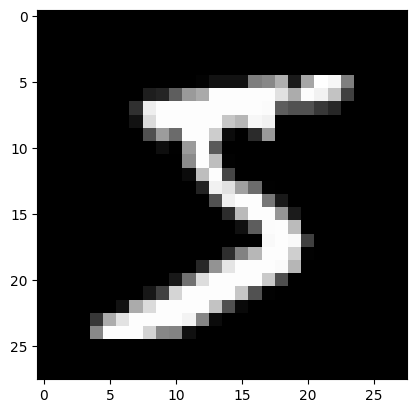

In [4]:
#BEGIN_SOLUTION
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print(colored("Training data features:", "blue"), X_train.shape)
print(colored("Training data labels:", "blue"),Y_train.shape)

print(colored("Test data features:", "blue"),X_test.shape)
print(colored("Test data labels:", "blue"),Y_test.shape)

print(colored("Trainig data example number 0:", "blue"), "label:",Y_train[0])
print(X_train[0])
#END_SOLUTION

plt.imshow(X_train[0], cmap='gray');

## Wstępne przygotowanie danych (ang. preprocessing)

Dane które analizujemy mają postać dwuwymiarowych macierzy, ale sieci neuronowe które dziś trenujemy przyjmują na wejściu jednowymiarowe wektory.

**Proszę:**

* zmienić kształt danych wejściowych na jednowymiarowe macierze - operacja "spłaszczenia"
* wypisać kształt macierzy po spłaszczeniu. Czy wymiar jest zgodny z oczekiwaniem?
* znormalizować wartości danych do zakresu **[0,1]** korzystając z funkcji ```numpy.amax(...)```

In [5]:
print(colored("Training data shape before flattening:","blue"),X_train.shape)
#BEGIN_SOLUTION
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
#END_SOLUTION
print(colored("Training data shape after flattening:","blue"),X_train.shape)

#BEGIN_SOLUTION
maxValue = float(np.amax(X_train))
#END_SOLUTION
print(colored("Maximum value in training data:","blue"),maxValue)

#BEGIN_SOLUTON
X_train = X_train.astype('float32')/maxValue
X_test = X_test.astype('float32')/maxValue
#END_SOLUTION

print(colored("Maximum value in training data after normalisation:","blue"), np.amax(X_train))

Training data shape before flattening: (60000, 28, 28)
Training data shape after flattening: (60000, 784)
Maximum value in training data: 255.0
Maximum value in training data after normalisation: 1.0


## Zmiana reprezentacji etykiet

Etykiety zawierają numer klasy - cyfry. Łatwiejszą do analizy postacią jest reprezentacja za pomocą słowa bitowego o długości równej licznie klas.
W takim słowie wszystkie bity, oprócz jednego - wskazującego na daną klasę mają wartość **0**:

```
Original label encoding: 5 shape: (60000,)
One hot label encoding: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] shape: (60000, 10)

```

Takie kodowanie nazywa się "one hot encoding".

**Proszę:**

* korzystając z funkcji ```tensorflow.one_hot(...)``` zamienić etykiety na reprezentację "one hot encoding"
* wypisać na ekran oryginalne i nowe kodowanie etykiety dla przykładu 0 ze zbioru uczącego

In [9]:
print(colored("Original label encoding:","blue"),Y_train[0], colored("shape:","blue"), Y_train.shape)

#BEGIN_SOLUTION
depth = 10
Y_train = tf.one_hot(Y_train, depth)
Y_test = tf.one_hot(Y_test, depth)
#END_SOLUTION

print(colored("One hot label encoding for training data:","blue"),Y_train[0], "shape:", Y_train.shape)
print(colored("One hot label encoding for test data:","blue"),Y_test[0], "shape:", Y_test.shape)

Original label encoding: 5 shape: (60000,)


2023-12-13 08:14:12.901746: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.29MiB (rounded to 2400000)requested by op OneHot
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-12-13 08:14:12.901773: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-12-13 08:14:12.901780: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 16, Chunks in use: 16. 4.0KiB allocated for chunks. 4.0KiB in use in bin. 116B client-requested in use in bin.
2023-12-13 08:14:12.901785: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2023-12-13 08:14:12.901790: I tensorflow/tsl/framework/bfc_allocator.cc:1046] B

ResourceExhaustedError: {{function_node __wrapped__OneHot_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[60000,10] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:OneHot] name: 

## Definicja architektury sieci neuronowej

**Proszę:**

* przeanalizować funkcję ```getModel(nHidden, nNeurons, inputWidth, outputWidth)``` która tworzy model o zadanej liczbe warstw ukrytych ```nHidden``` z zadaną liczbą neuronów w każdej warstwie ```nNeurons``` przyjmujący na wejściu wektor o długości ```inputWidth```
* korzystając z funkcji ```getModel(nHidden, nNeurons, inputWidth, outputWidth)``` zdefiniować sieć neuronową o architekturze w pełni połączonej (ang. fully connected). Sieć powinna mieć:
    * warstwę wejściową
    * 4 warstwy ukryte o 500 neuronach każda z funkcją aktywacji ```relu```
    * wartę wyjściową z funkcją aktywacji ```sofmax``` 
* obliczyć samodzielnie liczbę parametrów pierwszej warstwy ukrytej i porównać ją z wynikiem działania funkcji ```model.summary(...)```
* obejrzeć rysunek przedstawiający architekturę modelu, uzyskany przy pomocy funkcji ```tf.keras.utils.plot_model(...)```

Number of parameters for the first hidden layer: 392500
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 500)               392500    
                                                                 
 dense_1 (Dense)             (None, 500)               250500    
                                                                 
 dense_2 (Dense)             (None, 500)               250500    
                                                                 
 dense_3 (Dense)             (None, 500)               250500    
                                                                 
 dense_4 (Dense)             (None, 500)               250500    
                                                                 
 dens

2023-12-13 08:13:50.971907: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-13 08:13:50.972069: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-13 08:13:50.972162: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

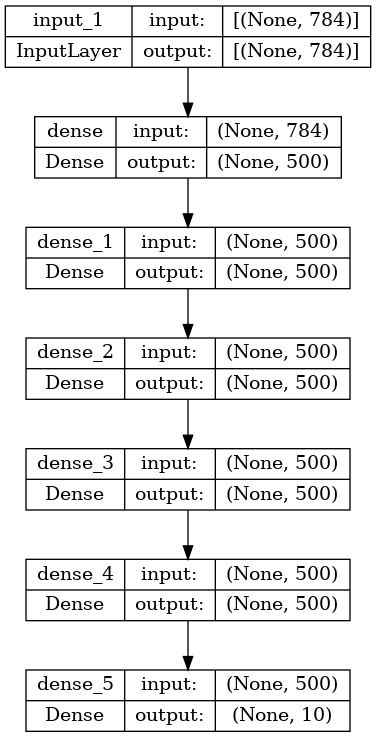

In [7]:
def getModel(nNeurons, nHiddenLayers, inputWidth, outputWidth):
      
    inputs = tf.keras.Input(shape=(inputWidth,))
    x = inputs
    for iHidden in range(nHiddenLayers):   
        x = tf.keras.layers.Dense(nNeurons, activation=tf.nn.relu)(x)
  
    outputs = tf.keras.layers.Dense(outputWidth, activation=tf.nn.softmax)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

#BEGIN_SOLUTION
nNeurons = 500
nHiddenLayers = 5
inputWidth = 28*28
outputWidth = 10
model_basic = getModel(nNeurons, nHiddenLayers, inputWidth, outputWidth)
nParams = inputWidth*nNeurons+nNeurons
#END_SOLUTION
print(colored("Number of parameters for the first hidden layer:","blue"), nParams)

model_basic.summary()
tf.keras.utils.plot_model(model_basic, 'ML_model.png', show_shapes=True)

## Trenowanie modelu

Trenowanie modelu polega na znalezieniu parametrów modelu dla których funkcja straty przyjmuje minimalną wartość. Problem ten w ogólności nie może być rozwiązany analitycznie i minimalizacja jest przeprowadzana numerycznie. Standardowym wyborem algorytmu minimalizacji jest 
[adaptive momemtum estimation](https://arxiv.org/abs/1412.6980). W sytuacji kiedy model ma za zadanie kategoryzację danych jako funkcję straty przyjmuje się zwykle entropię krzyżową (ang. crossentropy). W sytuacji kiedy klas jest więcej niż dwie trzeba użyć wariantu "categorical_crossentropy".


Trening jest prowadzony iteracyjnie. Każde przejście przez pełen zestaw danych jest **epoką**. Dane zwykle są podzielone na paczki **batch**.
Postęp treningu można monitorować używając wybranej metryki na danych uczących i testowych. Zwykle używa się dokładności.

**Proszę:**

* przeprowadzić trening dla `10` epok z rozmiarem paczki wynoszącym `128`
* jako algorytmu minimalizacji proszę użyć `adam`
* jako funkcji straty proszę użyć `categorical_crossentropy`
* jako metryki proszę użyć `accuracy`

**Uwaga**: po pierwszym treningu proszę połączyć środowisko wykonawcze by używało karty graficznej "GPU": z menu na górze:
```
Środowisko wykonawcze -> Zmień typ środowiska wykonawczego
```
Oczekiwany efekt:
```
Epoch 1/10
469/469 [==============================] - 2s 3ms/step - loss: 0.2286 - accuracy: 0.9302 - val_loss: 0.1268 - val_accuracy: 0.9619

...

Epoch 10/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0233 - accuracy: 0.9930 - val_loss: 0.0861 - val_accuracy: 0.9803
```

Proszę:
* porównać wartości metryki na danych uczących i testowych. Jaki wniosek wynika z tego porównania?

In [8]:
%%time 
#BEGIN_SOLUTION
epochs = 15
batch_size = 128

model_basic_fit = model_basic.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test))
#END_SOLUTION
pass

Epoch 1/15


ValueError: in user code:

    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py", line 1081, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/losses.py", line 2122, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/usr/local/lib/python3.8/dist-packages/keras/src/backend.py", line 5560, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 10) are incompatible


## Analiza historii treningu

Proszę uzupełnić funkcję ```plotTrainingHistory(model)``` tak by tworzyła wykresy:

* na jednym wykresie wartości metryki w funkcji numeru epoki obliczone dla danych uczących i treningowych
* na drugim wykresie funkcji straty  w zależności od numeru epoki obliczone dla danych uczących i treningowych

Wartości potrzebnych parametrów są dostępne w obiekcie ```Model.history```

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
[0.928600013256073, 0.9710666537284851, 0.9799833297729492, 0.9834666848182678, 0.9853500127792358, 0.9880666732788086, 0.9919000267982483, 0.9918000102043152, 0.9919499754905701, 0.993399977684021, 0.993149995803833, 0.9952666759490967, 0.9939833283424377, 0.9946833252906799, 0.9950000047683716]


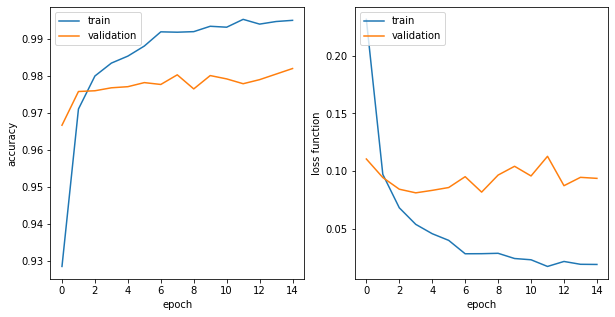

In [7]:
print(model_basic_fit.history.keys())
history = model_basic_fit.history
print(history['accuracy'])

def plotTrainingHistory(model):
    #BEGIN_SOLUTION
    fig, axes= plt.subplots(1,2,figsize=(10,5))
    history = model.history
    axes[0].plot(history['accuracy'])
    axes[0].plot(history['val_accuracy'])
    axes[0].set_ylabel('accuracy')
    axes[0].set_xlabel('epoch')
    axes[0].legend(['train', 'validation'], loc='upper left')

    axes[1].plot(history['loss'])
    axes[1].plot(history['val_loss'])
    axes[1].set_ylabel('loss function')
    axes[1].set_xlabel('epoch')
    axes[1].legend(['train', 'validation'], loc='upper left')
    #END_SOLUTION
      
plotTrainingHistory(model_basic_fit)   

## Sprawdzenie modelu na własnych danych

Proszę uruchomić komórkę poniżej i sprawdzić jak model rozpoznaje własnoręcznie napisane cyfry

**Uwaga** ten fragment działa tylko w Google Colaboratory

In [8]:
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB: 
    testModelOnMyDigits(model_basic)

## Regularyzacja procesu treningu

Analiza historii uczenia i wartości metryk na zbiorach uczącym i treningowym wskazuje, że uzyskany model nie generalizuje się dobrze - jego odpowiedź na dane których nie "widział" w czasie treningu jest gorsza niż na dane uczące. Jednym ze sposobów redukcji tego efektu jest **regularyzacja** modelu poprzez nałożenie 
różnych ograniczeń na proces uczenia. Mogą to być:

* zmiana liczby epok i zatrzymanie uczenia w chwili gdy metryka na zbiorze testowym się nie zmienia, lub pogarsza - ang. **early stopping**
* ograniczenia na wartości wag uzyskane przez dodawanie członów do funkcji straty kierujących proses uczenia to wybranego obszaru wag, np. małych wartości wag - **L1 or L2 penalty term**
* losowe wyłączanie neuronów - ang. **dropout**

### Early stopping

**Proszę:**

* stworzyć model ```model_early_stop``` o tej samej architekturze co model ```model_basic```
* przeprowadzić trening z opcją "early_stop": ```callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]``` Co oznacza parametr `patience`?
* narysować rysunki dla historii treningu

Czy moment przerwania treningu jest zgodny z oczekiwaniem?

Epoch 1/15
469/469 [==============================] - 1s 2ms/step - loss: 0.2247 - accuracy: 0.9312 - val_loss: 0.1078 - val_accuracy: 0.9674
Epoch 2/15
469/469 [==============================] - 1s 2ms/step - loss: 0.0963 - accuracy: 0.9708 - val_loss: 0.0967 - val_accuracy: 0.9710
Epoch 3/15
469/469 [==============================] - 1s 3ms/step - loss: 0.0692 - accuracy: 0.9792 - val_loss: 0.0777 - val_accuracy: 0.9765
Epoch 4/15
469/469 [==============================] - 1s 3ms/step - loss: 0.0530 - accuracy: 0.9837 - val_loss: 0.1179 - val_accuracy: 0.9665
Epoch 5/15
469/469 [==============================] - 1s 2ms/step - loss: 0.0464 - accuracy: 0.9863 - val_loss: 0.0939 - val_accuracy: 0.9766
Epoch 6/15
469/469 [==============================] - 1s 2ms/step - loss: 0.0367 - accuracy: 0.9887 - val_loss: 0.0822 - val_accuracy: 0.9796
Epoch 7/15
469/469 [==============================] - 1s 3ms/step - loss: 0.0332 - accuracy: 0.9903 - val_loss: 0.0862 - val_accuracy: 0.9805
Epoch 

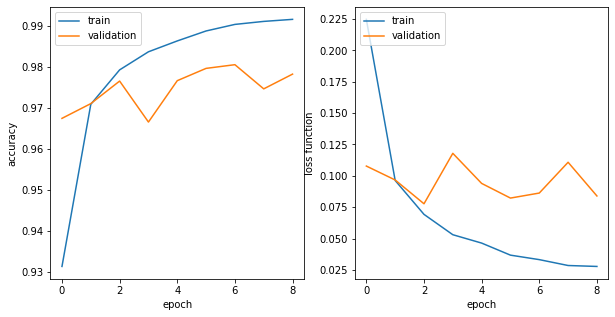

In [9]:
%%time
#BEGIN_SOLUTION
model_early_stop = getModel(nNeurons, nHiddenLayers, inputWidth, outputWidth)

model_early_stop_fit = model_early_stop.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test), 
                                        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])
#END_SOLUTION
plotTrainingHistory(model_early_stop_fit) 

### Regularyzacja L2 i L1

Regularyzacje L1 i L2 prowadzą do uzyskania modeli które mają małe wartości wag. Efekty ten uzyskuje się przez dodanie członu "kary" ang. "penalty term" do funkcji straty:
 
\begin{equation}
L_{1} = \lambda \sum_{i} w_{i},~~
L_{2} = \lambda \sum_{i} w_{i}^{2}
\end{equation}

gdzie $w_{i}$ to wagi modelu, a $\lambda$ to parametr skalujący wielkość członu kary.

**Proszę:**

* stworzyć model ```model_L2``` o tej samej architekturze co model ```model_basic``` z regularyzacją L2 dla każdej warstwy. Efekt ten możne uzyskać na co najmniej dwa sposoby:
    * napisać nową funkcję ```getModelWithL2(...)``` z opcją regularyzacji L2 dla każdej warstwy: ```kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)```
    * dodać regularyzację dla warstw istniejącego modelu:
    
      ```
      layers = model_basic.layers
      ...
      layer.kernel_regularizer =  tf.keras.regularizers.l2(l2_lambda)
      ```
      W tym wypadku należy skompilowac model powtórnie:
      ```
      model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
      ```
* przeprowadzić trening z parametrami jak poprzednio
* narysować rysunki dla historii treningu

Epoch 1/15
469/469 [==============================] - 1s 2ms/step - loss: 0.2231 - accuracy: 0.9313 - val_loss: 0.1115 - val_accuracy: 0.9666
Epoch 2/15
469/469 [==============================] - 1s 3ms/step - loss: 0.0979 - accuracy: 0.9711 - val_loss: 0.0854 - val_accuracy: 0.9751
Epoch 3/15
469/469 [==============================] - 1s 2ms/step - loss: 0.0718 - accuracy: 0.9782 - val_loss: 0.0843 - val_accuracy: 0.9750
Epoch 4/15
469/469 [==============================] - 1s 2ms/step - loss: 0.0536 - accuracy: 0.9834 - val_loss: 0.0992 - val_accuracy: 0.9735
Epoch 5/15
469/469 [==============================] - 1s 2ms/step - loss: 0.0403 - accuracy: 0.9877 - val_loss: 0.0929 - val_accuracy: 0.9754
Epoch 6/15
469/469 [==============================] - 1s 2ms/step - loss: 0.0371 - accuracy: 0.9889 - val_loss: 0.0878 - val_accuracy: 0.9770
Epoch 7/15
469/469 [==============================] - 1s 2ms/step - loss: 0.0319 - accuracy: 0.9906 - val_loss: 0.0751 - val_accuracy: 0.9787
Epoch 

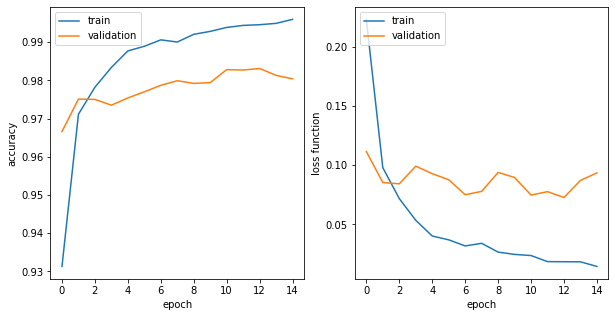

In [10]:
l2_lambda = 0.001
#BEGIN_SOLUTION
model_L2 = getModel(nNeurons, nHiddenLayers, inputWidth, outputWidth)

for layer in model_L2.layers:
    layer.kernel_regularizer =  tf.keras.regularizers.l2(l2_lambda)
 
model_L2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_L2_fit = model_L2.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test))
#END_SOLUTION
plotTrainingHistory(model_L2_fit)   

### Dropout

Opuszczanie neuronów (ang. dropout) polega na dezaktywacji losowych neutronów w czasie treningu. Dezaktywacja neuronów jest uzyskiwana przez zerowanie wagi danego neuronu względem następnej wartswy. Efekt ten uzyskuje się przez wstawienie dedykowanej warstwy - `tf.keras.Dropout` po warstwie w której mają być dezaktywowane neurony.

**Proszę:**

* napisać funkcję ```getModelWithDropout(nNeurons, nHiddenLayers, inputWidth, outputWidth, dropout_rate)``` która tworzy model z warstwami "Dropout" po każdej warstwie ukrytej
* stworzyć model ```model_droput``` o tej samej architekturze co model ```model_basic``` z warstwami `Dropout` po każdej warstwie ukrytej
* wypisać na ekran architekturę modelu, używając funkcji ```model.summary()``` i sprawdzić czy struktura modelu jest zgodna z oczekiwaniem
* przeprowadzić trening z parametrami jak poprzednio
* narysować rysunki dla historii treningu

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_18 (Dense)            (None, 500)               392500    
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_19 (Dense)            (None, 500)               250500    
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                                 
 dense_20 (Dense)            (None, 500)               250500    
                                                                 
 dropout_2 (Dropout)         (None, 500)               0   

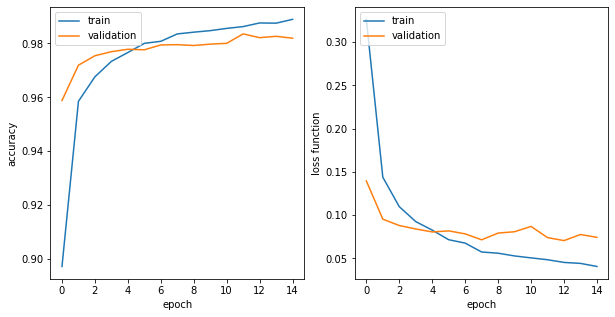

In [11]:
#BEGIN_SOLUTION
def getModelWithDropout(nNeurons, nHiddenLayers, inputWidth, outputWidth, dropout_rate):
      
    inputs = tf.keras.Input(shape=(inputWidth,))
    x = inputs
    for iHidden in range(nHiddenLayers):   
        x = tf.keras.layers.Dense(nNeurons, activation=tf.nn.relu)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
  
    outputs = tf.keras.layers.Dense(outputWidth, activation=tf.nn.softmax)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

dropout_rate = 0.25
model_dropout = getModelWithDropout(nNeurons, nHiddenLayers, inputWidth, outputWidth, dropout_rate)
model_dropout.summary()

model_dropout_fit = model_dropout.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test))
#END_SOLUTION
plotTrainingHistory(model_dropout_fit) 

### Połączenie metod L2 i dropout 

**Proszę:**

* napisać funkcję ```getModelWithDropoutWithL2(nNeurons, nHiddenLayers, inputWidth, outputWidth, dropout_rate, l2_lambda)``` która tworzy model o tej samej architekturze co model ```model_basic``` z warstwami "Dropout" po każdej warstwie ukrytej, oraz regularyzacją typu L2
* stworzyć model ```model_droput_L2```
* wypisać na ekran architekturę modelu, używając funkcji ```model.summary()``` i sprawdzić czy struktura modelu jest zgodna z oczekiwaniem
* przeprowadzić trening z parametrami jak poprzednio
* narysować rysunki dla historii treningu. 
* **proszę przeanalizować i skomentować wykresy**. Czy są one zgodne wykresami dla innych modeli?

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_24 (Dense)            (None, 500)               392500    
                                                                 
 dropout_5 (Dropout)         (None, 500)               0         
                                                                 
 dense_25 (Dense)            (None, 500)               250500    
                                                                 
 dropout_6 (Dropout)         (None, 500)               0         
                                                                 
 dense_26 (Dense)            (None, 500)               250500    
                                                                 
 dropout_7 (Dropout)         (None, 500)               0   

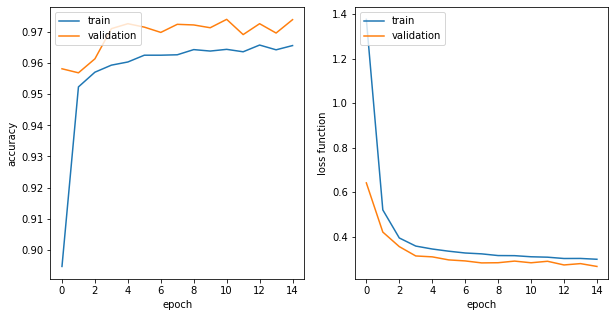

In [12]:
#BEGIN_SOLUTION
def getModelWithDropoutWithL2(nNeurons, nHiddenLayers, inputWidth, outputWidth, dropout_rate, l2_lambda):
      
    inputs = tf.keras.Input(shape=(inputWidth,))
    x = inputs
    for iHidden in range(nHiddenLayers):   
        x = tf.keras.layers.Dense(nNeurons, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(l2_lambda))(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
  
    outputs = tf.keras.layers.Dense(outputWidth, activation=tf.nn.softmax)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

l2_lambda = 1E-3
dropout_rate = 0.25
model_dropout_L2 = getModelWithDropoutWithL2(nNeurons, nHiddenLayers, inputWidth, outputWidth, dropout_rate, l2_lambda)
model_dropout_L2.summary()
model_dropout_L2_fit = model_dropout_L2.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test))
#END_SOLUTION
plotTrainingHistory(model_dropout_L2_fit) 

### Walidacja modelu

Który z wariantów jest optymalny? Czy mamy wystarczające dane by odpowiedzieć na to pytanie? 

**Proszę:**

* korzystając z funkcji ```sklearn.model_selection.train_test_split(...)``` podzielić zbiór uczący na nowy zbiór uczący oraz zbiór  walidacyjny w stosunku 7:3
* korzystając ze zbiorów uczącego i walidacyjnego wybrać optymalny model
* przeprowadzić trening modeli: `basic`, `early_stop`, `L2` i `L2_dropout` sprawdzając wydajność modelu na zbiorze walidacyjnym. W czasie treningu można zmniejszyć ilość wypisywanych danych używając parametru ```verbose=0```
* wybrać model o najlepszej dokładności
* sprawdzić dokładność wybranego modelu na zbiorze testowym

In [13]:
#BEGIN_SOLUTION
from sklearn.model_selection import train_test_split

#Reload the data
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=0.3)

#Check the shapes
print("Train dataset shape:",X_train.shape)
print("Validation dataset shape:",X_validation.shape)
print("Validation dataset shape:",X_test.shape)

#Flatten the data
X_train = X_train.reshape(X_train.shape[0], -1)
X_validation = X_validation.reshape(X_validation.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

#Normalise the data
maxValue = float(np.amax(X_train))

X_train = X_train.astype('float32')/maxValue
X_validation = X_validation.astype('float32')/maxValue
X_test = X_test.astype('float32')/maxValue

#Recode the labels
depth = 10
Y_train = tf.one_hot(Y_train, depth)
Y_validation = tf.one_hot(Y_validation, depth)
Y_test = tf.one_hot(Y_test, depth)

#Traing the models
model_basic_fit = model_basic.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_validation, Y_validation), verbose=0)

model_early_stop_fit = model_early_stop.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_validation, Y_validation), 
                                        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)],verbose=0)

model_L2_fit = model_L2.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_validation, Y_validation),verbose=0)

model_dropout_L2_fit = model_dropout_L2.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_validation, Y_validation),verbose=0)


models = {"model_basic": (model_basic, model_basic_fit), 
              "model_early_stop": (model_early_stop, model_early_stop_fit),
              "model_L2":  (model_L2, model_L2_fit),
              "model_dropout_L2": (model_dropout_L2, model_dropout_L2_fit)
             }

accuaracy = {name:model[1].history["accuracy"][-1] for name, model in models.items()}
bestModelName = max(accuaracy, key=accuaracy.get)
print(colored("Models accuracy:","blue")) 
for name, value in accuaracy.items():
    print(name,"\t:",value)

print(colored("Best model:","blue"))
print(bestModelName,"\t:",accuaracy[bestModelName])
#END_SOLUTION
print(colored("Best model metric on test data:","blue"))
results = models[bestModelName][0].evaluate(X_test, Y_test, batch_size=128)

Train dataset shape: (42000, 28, 28)
Validation dataset shape: (18000, 28, 28)
Validation dataset shape: (10000, 28, 28)
Models accuracy:
model_basic 	: 0.9982380867004395
model_early_stop 	: 0.9947618842124939
model_L2 	: 0.9979047775268555
model_dropout_L2 	: 0.9710000157356262
Best model:
model_basic 	: 0.9982380867004395
Best model metric on test data:
79/79 [==============================] - 0s 1ms/step - loss: 0.1228 - accuracy: 0.9816


## Zadanie domowe

### Warstawa spłaszczająca

Pierwsza operacja wstępnej analizy danych polegała na spłaszczeniu wielowymiarowej struktury do jednowymiarowego wektora. To jest częsta operacja i zdefiniowano dla niej odpowiednią warstwę (ang. layer).

**Proszę:**

* korzystając z warstwy spłaszczającej napisać funkcję ```getModelFinal(...)``` która tworzy model ze wszystkim elementami (regularyzacja L2, dropout) który na wejściu przyjmuje oryginalne rysunki

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_30 (Dense)            (None, 500)               392500    
                                                                 
 dropout_10 (Dropout)        (None, 500)               0         
                                                                 
 dense_31 (Dense)            (None, 500)               250500    
                                                                 
 dropout_11 (Dropout)        (None, 500)               0         
                                                                 
 dense_32 (Dense)            (None, 500)               2505

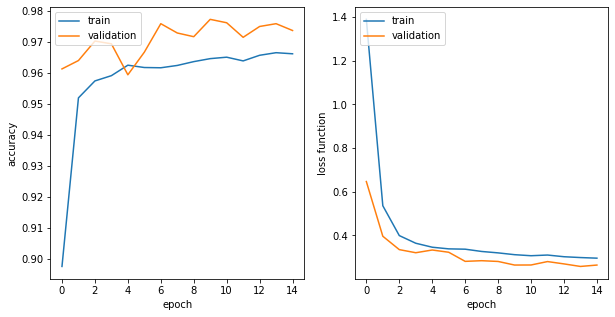

In [14]:
#BEGIN_SOLUTION
def getModelFinal(nNeurons, nHiddenLayers, inputWidth, outputWidth, dropout_rate, l2_lambda):
      
    inputs = tf.keras.Input((28,28,))
    x = inputs
    x = tf.keras.layers.Flatten()(x)
    for iHidden in range(nHiddenLayers):   
        x = tf.keras.layers.Dense(nNeurons, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(l2_lambda))(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
  
    outputs = tf.keras.layers.Dense(outputWidth, activation=tf.nn.softmax)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

dropout_rate = 0.25
l2_lambda = 0.001
model_final = getModelFinal(nNeurons, nHiddenLayers, inputWidth, outputWidth, dropout_rate, l2_lambda)
model_final.summary()

#Reload the data
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

#Normalise the data
maxValue = float(np.amax(X_train))

X_train = X_train.astype('float32')/maxValue
X_test = X_test.astype('float32')/maxValue

#Recode the labels
depth = 10
Y_train = tf.one_hot(Y_train, depth)
Y_test = tf.one_hot(Y_test, depth)
model_final_history = model_final.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test), verbose=0)

print(colored("Model metric on test data:","blue"))
results = model_final.evaluate(X_test, Y_test, batch_size=128)

#END_SOLUTION
plotTrainingHistory(model_final_history) 